Titanic Data Head:
    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. T

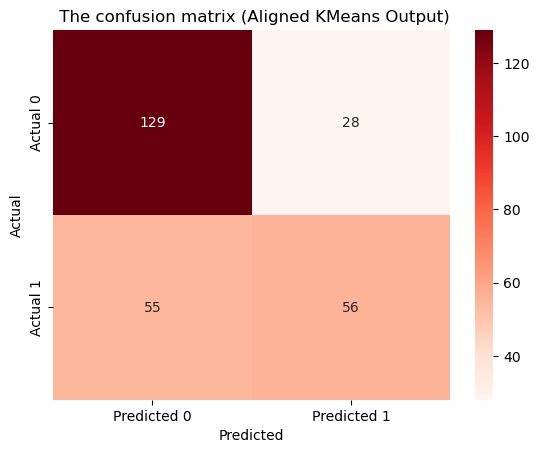

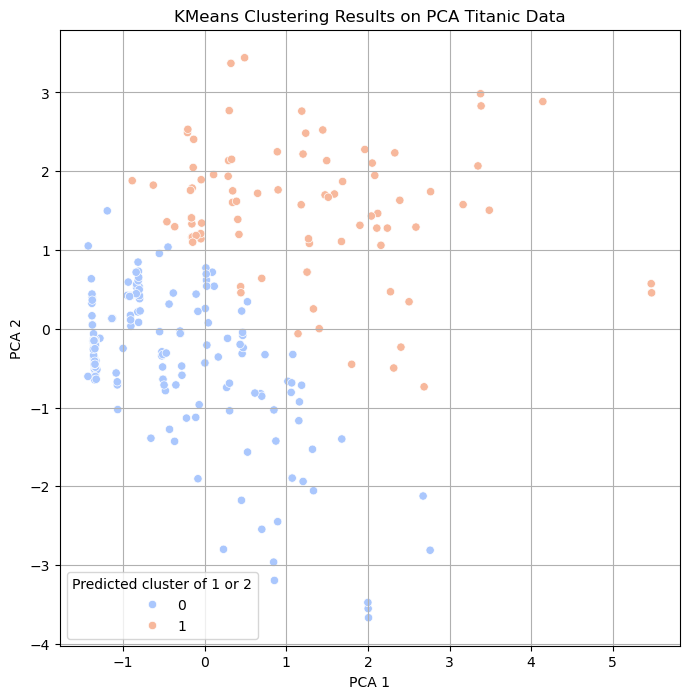

The kmeans clustering on PCA data gives an accuracy of 69% with proper class distribution as shown in the scatt

KMeans Cluster vs. Actual Survival:

   KMeans_Cluster  Actual_Survived
0               1                1
1               0                0
2               0                1
3               0                0
4               0                0
Actual_Survived    0    1
KMeans_Cluster           
0                330  134
1                 62   97


In [42]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
# I continued the Titanic dataset route and selected the data from the cluster dataset folder
# This accuracy will be dependent on PSA transformed data on an unsupervised algorithm
# The dataset is different from Part 1 in some ways, but will be going with a similar approach

# The Titanic dataset from clusters folder
df = pd.read_csv('Titanic-Dataset.csv')

# The basic info
print("Titanic Data Head:\n", df.head(10))
print("\nMissing:\n", df.isnull().sum())
print("Rows",len(df)) #Number of rows 891
# Removed the print(df.describe()) as it got flagged so making some changes to ellaboarate my process some more

# feature, I wanted to try this method as it's similar but different to part 1 as this version of the titanic dataset has 'survived' in different casings
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived' if 'Survived' in df.columns else 'survived'  # Just in case casing differs in data

# preprocessing the missing values
df['Age'] = SimpleImputer(strategy='mean').fit_transform(df[['Age']])
df['Embarked'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['Embarked']]).ravel()

# encode the categoricals
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])
X = df[features]
y = df[target] # The target is already defined from features

# train and test split with 30% on state 42 like in part 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

# PCA on training and fit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the PCA with 2 components
pca = PCA(n_components=2) # Used 2 components for PCA
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Here I will use KMeans clustering with the KMeans() and make predictions
kmeans = KMeans(n_clusters=2, random_state=42) # 2 clusters on state 42
kmeans.fit(X_train_pca)
y_train_pred = kmeans.predict(X_train_pca)
y_test_pred = kmeans.predict(X_test_pca)

# Align KMeans output with survived labels

def align_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        labels[mask] = mode(y_true[mask])[0]
    return labels

y_test_aligned = align_clusters(y_test.values, y_test_pred)

# Evaluating the data and confusion matrix added with a plot
# High accuracy score of 69% for the PCA transformed data

accuracy = accuracy_score(y_test, y_test_aligned)
print("\nKMeans Accuracy after alignment:", accuracy)

c = confusion_matrix(y_test, y_test_aligned)
sns.heatmap(c, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(" The confusion matrix (Aligned KMeans Output)")
plt.show()

# Plotting Clusters with scatterplot
# Plotted graph has 2 distinct clusters near component 1 and component 2
plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test_aligned, palette='coolwarm')
plt.title('KMeans Clustering Results on PCA Titanic Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Predicted cluster of 1 or 2')
plt.grid(True)
plt.show()

print("The kmeans clustering on PCA data gives an accuracy of 69% with proper class distribution as shown in the scatt")

# KMeans clusters to actual survival on the data, a comparison of the accuracy shown before as we did SVM in part 1
kmeans_vs_true = pd.DataFrame({
    'KMeans_Cluster': kmeans.labels_,
    'Actual_Survived': y_train.values
})
print("\nKMeans Cluster vs. Actual Survival:\n")
print(kmeans_vs_true.head(5))
print(pd.crosstab(kmeans_vs_true['KMeans_Cluster'], kmeans_vs_true['Actual_Survived']))